# Routing Weight Optimization: Data Processing and Training Workflow

This notebook runs the main workflow for the offline RL agent:
1. **Setup:** Clones the repo (or pulls updates), installs dependencies, and sets up paths.
2. **Data Preparation:** Runs the `create_dataset.py` script to generate the `MDPDataset`.
3. **Model Training:** Runs the `train_cql.py` script to train the CQL agent.
4. **Basic Results:** Loads and plots some training metrics.

## 1. Setup

In [2]:
import os
import subprocess

# Check if already logged into GitHub
print("Checking GitHub authentication status...")
try:
    result = subprocess.run(['gh', 'auth', 'status'], capture_output=True, text=True)
    if "Logged in to github.com" in result.stdout:
        print("Already logged in to GitHub.")
    else:

        # Install GitHub CLI (if not already installed)
        print("Ensuring GitHub CLI is installed...")
        !apt-get update > /dev/null && apt-get install -y gh > /dev/null
        print("GitHub CLI installed.")

        # Authenticate with GitHub (should use cached credentials)
        print("\nAuthenticating with GitHub CLI (use cached credentials if available)...")
        !gh auth login --hostname github.com -w

        # Explicitly configure git to use gh as the credential helper
        print("\nConfiguring git credential helper using 'gh auth setup-git'...")
        !gh auth setup-git
except Exception as e:
    # If gh command fails, install and authenticate
    print(f"Error checking auth status: {e}")
    print("Ensuring GitHub CLI is installed...")
    !apt-get update > /dev/null && apt-get install -y gh > /dev/null
    print("GitHub CLI installed.")

    # Authenticate with GitHub (should use cached credentials)
    print("\nAuthenticating with GitHub CLI (use cached credentials if available)...")
    !gh auth login --hostname github.com -w

    # Explicitly configure git to use gh as the credential helper
    print("\nConfiguring git credential helper using 'gh auth setup-git'...")
    !gh auth setup-git

# --- Attempt standard git clone AFTER configuration ---
print("\nAttempting git clone...")
# Define repo URL and target directory
repo_url = "https://github.com/saikanam/openRoad-dr-training.git"
target_dir = "/content/openRoad-dr-training"

# Use standard git clone
clone_cmd = f"git clone {repo_url} {target_dir}"
!{clone_cmd} # Execute the clone command

# --- Check results and change directory ---
try:
    # Check if the directory exists and is not empty
    if os.path.exists(target_dir) and os.listdir(target_dir):
        print(f"\nRepository seems to be cloned successfully into {target_dir}")
        %cd {target_dir}
        print(f"Current working directory: {os.getcwd()}")
        # List contents to verify
        print("\nListing repository contents:")
        !ls -al
    else:
        print(f"\nError: Cloning appears to have failed. Directory {target_dir} is missing or empty.")
        print("\nChecking GitHub CLI auth status:")
        !gh auth status
        print("\nChecking git config for credential helper:")
        !git config --global --get credential.helper

except Exception as e:
    print(f"\nError changing directory or listing contents: {e}")
    print("Please check if the repository was cloned successfully.")

Checking GitHub authentication status...
Ensuring GitHub CLI is installed...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
GitHub CLI installed.

Authenticating with GitHub CLI (use cached credentials if available)...

! First copy your one-time code: D84B-F624
- Press Enter to open github.com in your browser... 
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'https://github.com/login/device'
! Failed opening a web browser at https://github.com/login/device
  exit status 3
  Please try entering the URL in your browser manually
✓ Authentication complete. Press Enter to continue...

✓ Logged in as saikanam

In [4]:
# === Google Colab Setup ===
# Clone the repository (if not already done) and pull latest changes

import os

REPO_NAME = "openRoad-dr-training" # Your repository name
# Use HTTPS URL for easier public/token access in Colab by default
# You might need to generate a Personal Access Token (PAT) on GitHub
# and use it in the URL like: https://<YOUR_PAT>@github.com/saikanam/openRoad-dr-training.git
# Or configure SSH keys if you prefer.
REPO_URL_HTTPS = "https://github.com/saikanam/openRoad-dr-training.git"

# Check if running in Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Google Colab")
    # Check if repo already exists in Colab's /content directory
    colab_repo_path = f"/content/{REPO_NAME}"
    if not os.path.exists(colab_repo_path):
        print(f"Cloning repository: {REPO_URL_HTTPS} into {colab_repo_path}")
        # Clone using HTTPS
        !git clone {REPO_URL_HTTPS} {colab_repo_path}
        %cd {colab_repo_path}
    else:
        print(f"Repository {REPO_NAME} already exists in /content. Pulling latest changes...")
        %cd {colab_repo_path}
        !git pull origin main
else:
    # Assume running locally, repository is the current directory
    print("Running locally, repository assumed to be current directory.")
    # Optionally, you could still run git pull here if desired
    # !git pull origin main
    pass

print(f"\nCurrent directory: {os.getcwd()}")

Running in Google Colab
Repository openRoad-dr-training already exists in /content. Pulling latest changes...
/content/openRoad-dr-training
From https://github.com/saikanam/openRoad-dr-training
 * branch            main       -> FETCH_HEAD
Already up to date.

Current directory: /content/openRoad-dr-training


In [24]:
!git fetch
!git pull

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 3), reused 5 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 388 bytes | 388.00 KiB/s, done.
From https://github.com/saikanam/openRoad-dr-training
   e6de848..82f2868  main       -> origin/main
Updating e6de848..82f2868
Fast-forward
 src/training/train_cql.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [9]:
# === Install Dependencies ===
print("Installing dependencies from requirements.txt...")
!pip install -r requirements.txt --force

Installing dependencies from requirements.txt...
  Using cached d3rlpy-2.8.1-py3-none-any.whl.metadata (11 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.6 MB/s eta 0:00:00
  Using cached gym-0.26.2-py3-none-any.whl
  Using cached structlog-25.2.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached gymnasium-1.0.0-py3-none-any.whl.metadata (9.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-no

In [17]:
# === Imports and Path Definitions ===
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import d3rlpy # Verify import after install

# Define relative paths (should work relative to repo root)
DATA_INPUT_DIR = "training_data" # Relative path from create_dataset.py default
DATA_OUTPUT_DIR = "data"
DATASET_FILENAME = "routing_dataset.h5"
DATASET_PATH = os.path.join(DATA_OUTPUT_DIR, DATASET_FILENAME)
SCALER_PATH = os.path.join(DATA_OUTPUT_DIR, "state_scaler.pkl")
LOG_DIR = "d3rlpy_logs"

# Ensure output directories exist
os.makedirs(DATA_OUTPUT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

print(f"Dataset will be saved to: {DATASET_PATH}")
print(f"Scaler will be saved to: {SCALER_PATH}")
print(f"Training logs will be saved in: {LOG_DIR}")

Dataset will be saved to: data/routing_dataset.h5
Scaler will be saved to: data/state_scaler.pkl
Training logs will be saved in: d3rlpy_logs


## 2. Data Preparation

Run the script to process the raw CSV data into the `MDPDataset` format required by d3rlpy. This assumes the `training_data` directory exists at the root of the repository.

In [21]:
# === Run Data Creation Script ===
# Note: This assumes the 'training_data' folder is present in the root
# of the repository when cloned. It's not tracked by Git currently.

if not os.path.exists(DATA_INPUT_DIR):
    print(f"Warning: Input data directory '{DATA_INPUT_DIR}' not found. \n",
          f"Please ensure it exists in the repository root ('{os.getcwd()}') before running this step.")
else:
    print(f"Running data creation script... Input: {DATA_INPUT_DIR}, Output Dir: {DATA_OUTPUT_DIR}")
    !python src/data_processing/create_dataset.py --input_dir {DATA_INPUT_DIR} --output_dir {DATA_OUTPUT_DIR} --output_filename {DATASET_FILENAME}

    # === Verify Output ===
    if os.path.exists(DATASET_PATH):
        print(f"\nDataset file created successfully at: {DATASET_PATH}")
    else:
        print(f"\nError: Dataset file not found at {DATASET_PATH}. Check script output above.")

    if os.path.exists(SCALER_PATH):
        print(f"State scaler file created successfully at: {SCALER_PATH}")
    else:
        print(f"Error: State scaler file not found at {SCALER_PATH}. Check script output above.")

 Please ensure it exists in the repository root ('/content/openRoad-dr-training') before running this step.


## 3. Model Training

Run the training script using the generated dataset. Adjust hyperparameters as needed.

In [25]:
# === Training Configuration ===
# Using parameters that showed some promise previously (low LR, low alpha, no reward scaling)
EXPERIMENT_NAME = "CQL_Colab_Run_v3" # Increment experiment name
CONSERVATIVE_WEIGHT = 1.0
ACTOR_LR = 1e-6
CRITIC_LR = 1e-6
EPOCHS = 50 # Adjust as needed
USE_REWARD_SCALER_FLAG = "--no-use_reward_scaler" # Use '--use_reward_scaler' to enable
DEVICE_FLAG = "--use_gpu" # Use '--use_cpu' if no GPU available in Colab
SEED = 42 # Set a random seed for reproducibility

# === Run Training Script ===
print(f"Starting training run: {EXPERIMENT_NAME}")
if not os.path.exists(DATASET_PATH):
    print(f"Error: Dataset file not found at {DATASET_PATH}. Cannot start training.")
else:
    !python src/training/train_cql.py \
        --dataset {DATASET_PATH} \
        --experiment_name {EXPERIMENT_NAME} \
        --conservative_weight {CONSERVATIVE_WEIGHT} \
        --actor_lr {ACTOR_LR} \
        --critic_lr {CRITIC_LR} \
        --epochs {EPOCHS} \
        --seed {SEED} \
        {USE_REWARD_SCALER_FLAG}
        # Add other arguments as needed

    print(f"\nTraining finished. Logs should be available in: {os.path.join(LOG_DIR, EXPERIMENT_NAME)}")

Starting training run: CQL_Colab_Run_v3
--- Starting CQL Training --- 
Dataset: data/routing_dataset.h5
Log Directory: d3rlpy_logs/CQL_Colab_Run_v3
Epochs: 50
Seed: 42
Device: cuda
Hyperparameters: ActorLR=1e-06, CriticLR=1e-06, ConservWeight=1.0, Batch=256
Gradient Clipping Norm: 10.0
Initial Temperature: 1.0, Temp LR: 0.0001
Using Reward Scaler: False
Set d3rlpy random seed to 42
Loading dataset from data/routing_dataset.h5 into ReplayBuffer...
2025-04-07 21:02.23 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(11,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-04-07 21:02.23 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.CONTINUOUS: 1>
2025-04-07 21:02.23 [info     ] Action size has been automatically determined. action_size=4
Dataset loaded successfully into ReplayBuffer.

S

In [13]:
import torch
torch.cuda.is_available()

True

## 4. Basic Results

Load and plot some basic training metrics from the logs.

In [26]:
# === Load Logs ===
# Use the experiment name defined in the training cell
log_path = os.path.join(LOG_DIR, EXPERIMENT_NAME)
metrics_to_plot = [
    "critic_loss", "actor_loss", "temp_loss", "alpha_loss",
    "conservative_loss", "td_error", "initial_state_value",
    "temperature", "alpha" # Include temp and alpha if available
]

metrics_data = {}
print(f"Attempting to load logs from: {log_path}")

if os.path.exists(log_path):
    for metric in metrics_to_plot:
        csv_path = os.path.join(log_path, f"{metric}.csv")
        if os.path.exists(csv_path):
            try:
                metrics_data[metric] = pd.read_csv(csv_path)
                print(f"  Loaded {metric}.csv")
            except Exception as e:
                print(f"  Error loading {metric}.csv: {e}")
        else:
            # Don't print missing for optional ones like temp/alpha
            if metric not in ['temperature', 'alpha']:
                 print(f"  {metric}.csv not found.")
else:
    print(f"Log directory not found: {log_path}")

Attempting to load logs from: d3rlpy_logs/CQL_Colab_Run_v3
  Loaded critic_loss.csv
  Loaded actor_loss.csv
  Loaded temp_loss.csv
  alpha_loss.csv not found.
  Loaded conservative_loss.csv
  Loaded td_error.csv
  Loaded initial_state_value.csv
  Loaded alpha.csv


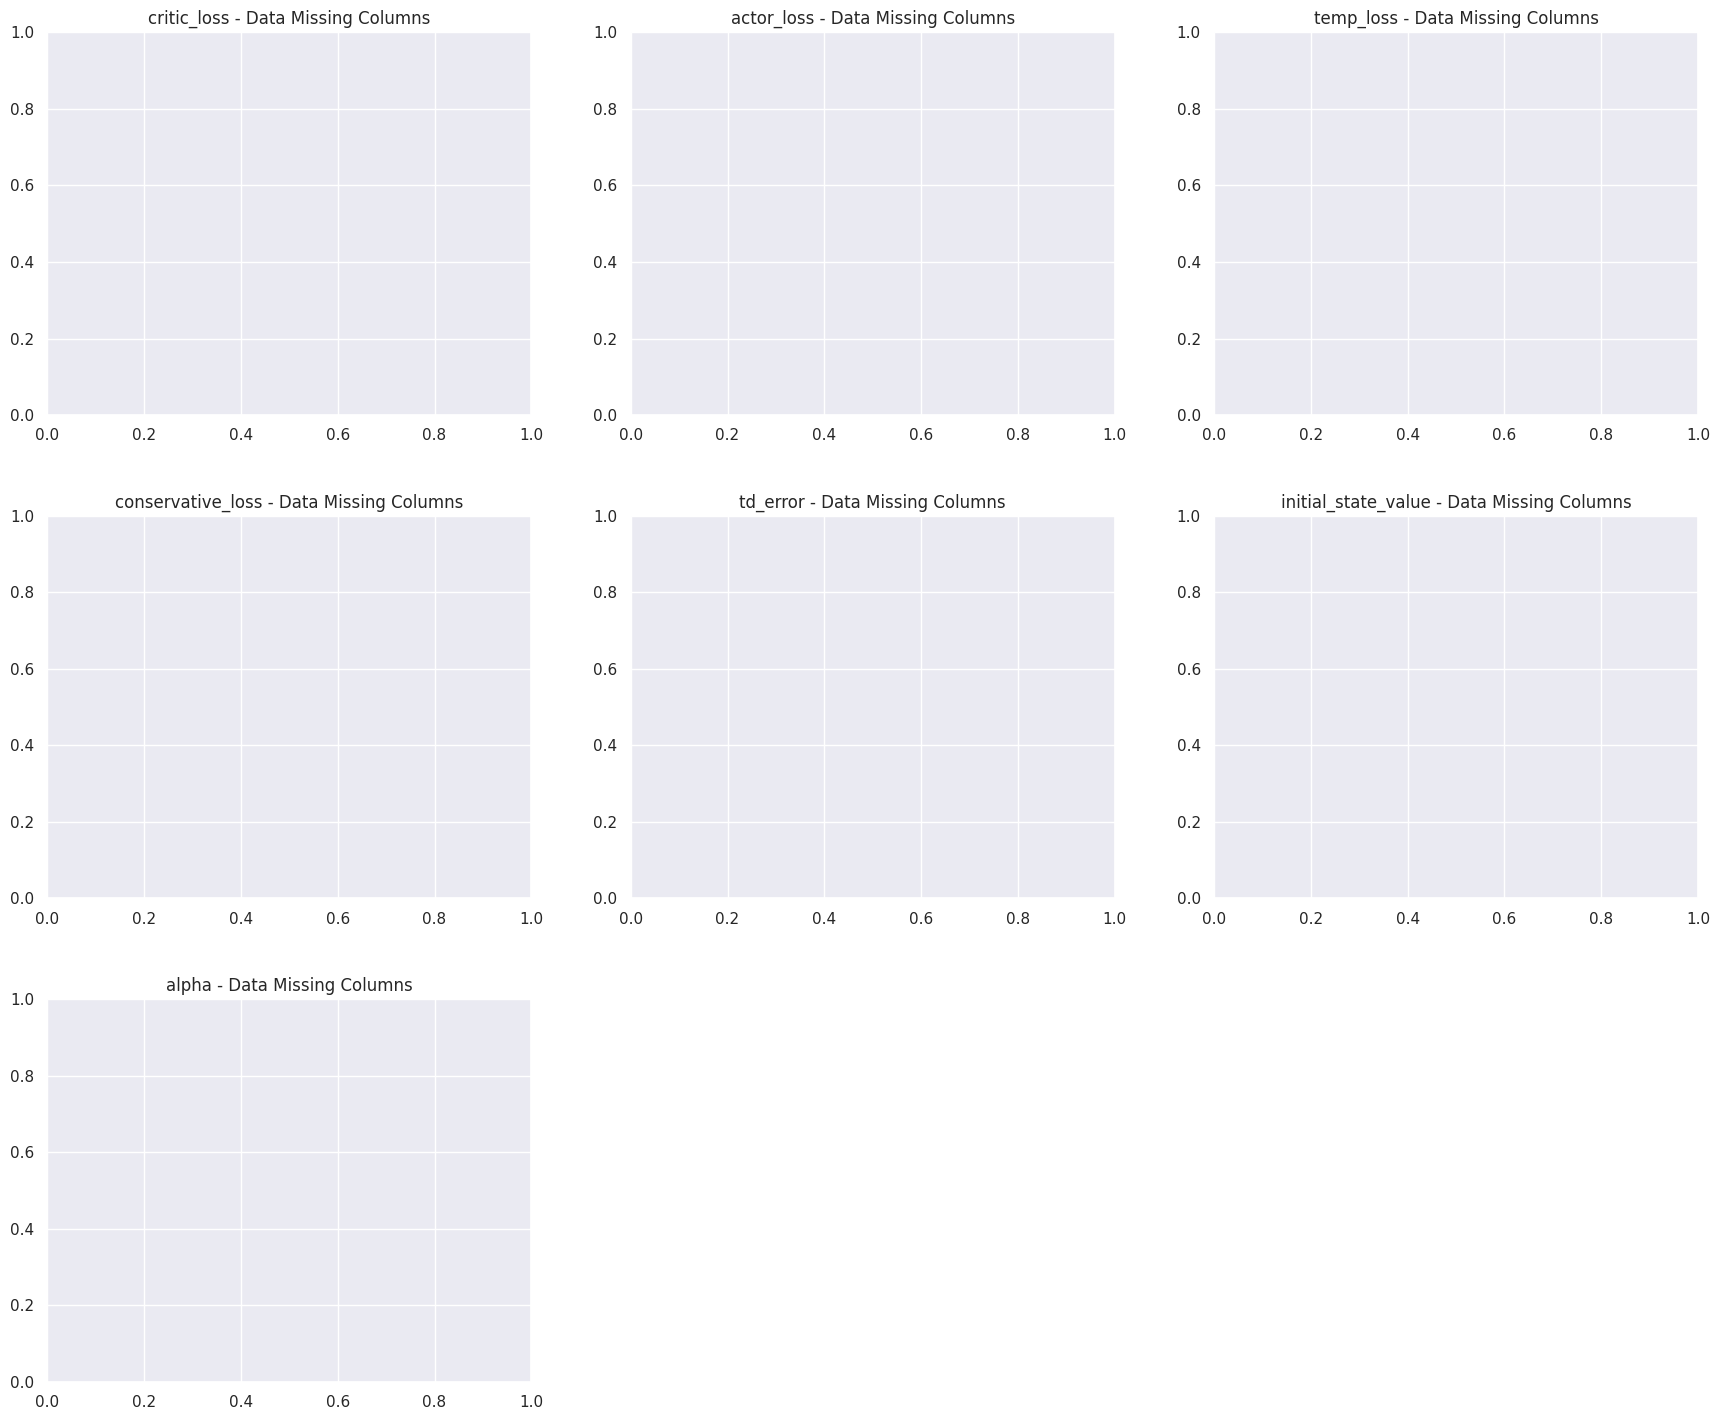

In [28]:
# === Plot Metrics ===
sns.set_theme(style="darkgrid")
num_metrics = len(metrics_data)

if num_metrics > 0:
    # Determine grid size (e.g., 3 columns)
    ncols = 3
    nrows = (num_metrics + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5 * nrows), squeeze=False)
    axes = axes.flatten() # Flatten to easily iterate

    plot_idx = 0
    for metric, df in metrics_data.items():
        if not df.empty:
            ax = axes[plot_idx]
            if 'step' in df.columns and 'value' in df.columns:
                sns.lineplot(data=df, x='step', y='value', ax=ax)
                ax.set_title(f"{metric} vs. Training Step")
                ax.set_xlabel("Training Step")
                ax.set_ylabel(metric.replace('_', ' ').title())
            else:
                ax.set_title(f"{metric} - Data Missing Columns")
            plot_idx += 1

    # Hide unused subplots
    for i in range(plot_idx, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout(pad=3.0)
    plt.show()
else:
    print("No metric data loaded to plot.")